In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:
G = nx.Graph()

df = pd.read_csv("../data/processed/N1_N2_plus_sideroads.csv")

In [3]:
for i in range(len(df)):
    G.add_node(df['id'][i], road=df['road'][i], length=df['length'][i],pos = [df['lon'][i],df['lat'][i]])

In [47]:
intersections = df.loc[df['model_type'] == "intersection"]
intersections = intersections.reset_index()
intersections.head()

index road       id    model_type condition name        lat        lon  \
0    132   N1  1000133  intersection       NaN  NaN  23.530805  90.781110   
1    156   N1  1000157  intersection       NaN  NaN  23.513111  90.870638   
2    157   N1  1000158  intersection       NaN  NaN  23.512667  90.871416   
3    208   N1  1000209  intersection       NaN  NaN  23.478972  91.117999   
4    209   N1  1000210  intersection       NaN  NaN  23.478972  91.118166   

   length bridge_name  
0   815.0         NaN  
1    42.0         NaN  
2   102.0         NaN  
3    28.0         NaN  
4    17.0         NaN

In [5]:
previousnode = -1
for i,row in df.iterrows():
    if previousnode != -1:
        if row['road'] == df.iloc[previousnode,0]:
            G.add_edge(df.iloc[previousnode,1], row['id'], weight=row['length'])
    previousnode = i

In [6]:
pos = nx.get_node_attributes(G,'pos')

In [7]:
nx.draw(G, pos = pos, with_labels = False, node_size = 5)

In [8]:
shortestpath_dict = {}

def find_shortest_path(graph, a,b):
    if (a,b) in shortestpath_dict:
        p = shortestpath_dict[(a,b)]
    else:
        p = nx.shortest_path(graph, source=a, target=b, weight = 'weight')
        shortestpath_dict.update({(a,b):p})
    return p

In [49]:
sourcesinks = df.loc[df['model_type'] == "sourcesink"]
sourcesinks = sourcesinks.reset_index()
sourcesinks.head()

index  road       id  model_type condition   name        lat        lon  \
0      0    N1  1000000  sourcesink       NaN  SoSi1  23.706028  90.443333   
1   1779  N102  1001782  sourcesink       NaN  SoSi2  24.050611  91.114667   
2   1910  N104  1001913  sourcesink       NaN  SoSi3  22.825749  91.101444   
3   2873    N2  1002995  sourcesink       NaN  SoSi4  25.157056  92.017638   
4   3165  N207  1003289  sourcesink       NaN  SoSi5  24.626333  91.677527   

   length bridge_name  
0     0.0         NaN  
1   549.0         NaN  
2   120.0         NaN  
3   256.0         NaN  
4   350.0         NaN

In [10]:
# show it works
find_shortest_path(G,1001784,1005956)

[1001784, 1005956]

In [11]:
found = 0
not_found = 0
for i, row in sourcesinks.iterrows():
    for j in range(1,len(sourcesinks)):
        try:
            find_shortest_path(G,row['id'],sourcesinks.iloc[j,2])
            #print("found path between",row['road'], "and", sourcesinks.iloc[j,1])
            found +=1
        except:
            print("could not find a path between",row['road'], "and", sourcesinks.iloc[j,1])
            not_found +=1
print(not_found/found*100,"percent of the paths could not be found")

0.0 percent of the paths could not be found


## Network metrics calculation

In [12]:
# compute the closeness centrality (takes a long time)

closenessdict = nx.closeness_centrality(G)

In [13]:
# compute the betweenness centrality (takes a long time)

betweennessdict = nx.betweenness_centrality(G)

In [14]:
# compute the degree centrality (runs quickly)

degreecentralitydict = nx.degree_centrality(G)

In [15]:
# save the results in a dataframe (throws some warnings which you can ignore)

bridges = df.loc[df['model_type'] == "bridge"]
bridgemetrics = bridges[['road','id','condition','bridge_name']]
bridgemetrics['betweenness_centrality'] = ''
bridgemetrics['closeness_centrality'] = ''
bridgemetrics['degreecentrality_centrality'] = ''

for i,row in bridgemetrics.iterrows():
    bridgemetrics['closeness_centrality'][i] = closenessdict[row['id']]
    bridgemetrics['betweenness_centrality'][i] = betweennessdict[row['id']]
    bridgemetrics['degreecentrality_centrality'][i] = degreecentralitydict[row['id']]

<ipython-input-15-6cb580415ec6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bridgemetrics['betweenness_centrality'] = ''
<ipython-input-15-6cb580415ec6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bridgemetrics['closeness_centrality'] = ''
<ipython-input-15-6cb580415ec6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [232]:
# show it worked
bridgemetrics.head()

road       id condition                bridge_name betweenness_centrality  \
4    N1  1000004         A       bridge at id 1000004             0.00136799   
10   N1  1000010         A       bridge at id 1000010             0.00341646   
17   N1  1000017         C  KANCHPUR PC GIRDER BRIDGE             0.00580101   
20   N1  1000021         B       KATCHPUR BOX CULVERT             0.00682121   
21   N1  1000022         A           NOYAPARA CULVERT             0.00716104   

   closeness_centrality degreecentrality_centrality degrees  
4            0.00135654                 0.000342173       2  
10           0.00136765                 0.000342173       2  
17           0.00138081                 0.000342173       2  
20           0.00138651                 0.000342173       2  
21           0.00138843                 0.000342173       2

In [233]:
# Save the results to csv 
bridgemetrics.to_csv("../data/output/network_metrics.csv", index=None)

### Most important intersections, based on degrees per node

In [239]:
from operator import itemgetter

In [240]:
# Create dictionairy with degree per node
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [241]:
# Sort the degree dictionairy and show the ten nodes with the highest degrees
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print(d)

Top 10 nodes by degree:
(1005956, 6)
(1006716, 6)
(1002141, 6)
(1004776, 6)
(1000950, 5)
(1002478, 4)
(1002679, 4)
(1004786, 4)
(1000133, 3)
(1000158, 3)


The 5 nodes with the highest degree are selected as the most important intersections, or 'hubs'

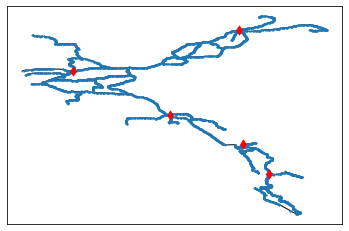

In [242]:
# Draw graph with highest degree hubs
Gsub = G.subgraph([1005956,1006716,1002141,1004776,1000950])
nx.draw_networkx(G,pos, with_labels = False, node_size = 1)
nx.draw_networkx(Gsub,pos,node_color = 'red', node_shape = 'd', with_labels = False, node_size = 40)
plt.show()

### Betweenness centrality

In [243]:
# Generate subset of bridges with the highest betweenness centrality. Threshold > 0.45.
df_between = bridgemetrics.sort_values('betweenness_centrality', ascending = False)
between = df_between.drop(df_between[df_between.betweenness_centrality < 0.45].index)
# Check
between

road       id condition                     bridge_name  \
3888  R203  1004077         A     BANCHARAMPUR-2-SLAB CULVERT   
3853  R203  1004042         C                 Bisnandi Bailey   
3852  R203  1004041         D                    Daribisnondi   
3844  R203  1004033         C             Ramchandradi Bridge   
3839  R203  1004028         C  SADADIA BAILEY WITH STEEL DECK   
...    ...      ...       ...                             ...   
195     N1  1000196         B             COREPAI BOX CULVERT   
197     N1  1000198         A            NIMSHAR SLAB CULVERT   
200     N1  1000201         C   KABILA DUBARCHAR SLAB CULVERT   
206     N1  1000207         B              NAZIRA BOX CULVERT   
207     N1  1000208         A         TIPRA BAZAR BOX CULVERT   

     betweenness_centrality closeness_centrality degreecentrality_centrality  \
3888               0.491918            0.0016853                 0.000342173   
3853               0.490315           0.00167211                 0.000342173   
3852               0.490267           0.00167172                 0.000342173   
3844                0.48988           0.00166856                 0.000342173   
3839               0.489634           0.00166656                 0.000342173   
...                     ...                  ...                         ...   
195                 0.46064           0.00168944                 0.000342173   
197                0.460597           0.00168908                 0.000342173   
200                0.460532           0.00168854                 0.000342173   
206                0.460403           0.00168747                 0.000342173   
207                0.460382           0.00168729                 0.000342173   

     degrees  
3888       2  
3853       2  
3852       2  
3844       2  
3839       2  
...      ...  
195        2  
197        2  
200        2  
206        2  
207        2  

[164 rows x 8 columns]

In [244]:
# Generate list based on df, for drawing the graph
b_list = []
b_list = between['id']

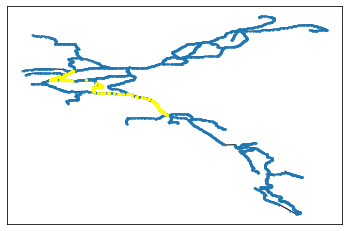

In [245]:
# Draw graph with betweenness areas, using the list based on threshold > 0.45
Gsub = G.subgraph(b_list)
nx.draw_networkx(G,pos, with_labels = False, node_size = 1)
nx.draw_networkx(Gsub,pos,node_color = 'yellow', with_labels = False, node_size = 5)
plt.show()

In [246]:
# Check the count of the conditions of the 'high betweenness centrality' - bridges
between['condition'].value_counts()

A    75
B    57
C    25
D     7
Name: condition, dtype: int64